# Introduction

Important Info:

Hi and welcome to the Sportlogiq DA Questionnaire! The goal with this questionnaire is to assess your problem solving, hockey knowledge, and coding/stats abilities and your (hopeful) fit with some of our day-to-day tasks. If you find yourself stuck or unsure on a question, showing your work and explaining your problem solving/decision making is still highly recommended.

Libraries:
- You'll want to import libraries such as numpy, pandas, a plotting library like plotly/matplotlib, and a stats library of your choosing (sklearn for example)

Data Info:
- There are two data files. One has a condensed event set from a randomly chosen hockey game and the other contains Expected Goals values (xg) provided only for shots that successfully hit the net. If an xg value doesn't correspond to a shot event, it should not be counted

- X and Y Coordinates are in Feet and are adjusted such that both teams shoot in the same direction

- Line Carry events are tagged when the puck is carried over either blue line or the centre ice red line

- Binary columns that have values of 0 or 1 indicate 0=No, 1=Yes

- Successfull passes are completed passes, successful shots are shots on net

Please show all work, keep written answers succinct and to the point and most of all, thanks for your time and good luck!

In [24]:
# Import libraries
import pandas as pd 
import plotly.express as px
import numpy as np
from math import sqrt 
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
import xgboost as xgb
from sklearn.metrics import confusion_matrix, accuracy_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Q1) 
### a) Who won the game & what was the score?
### b) Who won the Expected Goals (xg) battle & what was each team's total xg?
### c) What do these two answers tell us about how the two teams played?

### A1) Team 596 won. The score was 4-1 for team 596
#### b) Team 596 appears to have won the expected goals battle. As instructed, I did not count xg values that did not correspond with shot events. After I removed the non-corresponding xg values by completing an inner join between the condensed data and xg data, Team 596 had an expected goals of 4.63 and team 724 had an expected goals of 2.99.  Had I not removed the non-corresponding xg values, Team 596 would have had an expected goals of 4.74 and team 724 had an expected goals of 3.22.
#### c) Team 596 appears to have slightly over preformed its expected goals and team 724 appears to underperformed its expected goals. This means that given the quality of shots taken by team 724, they scored less goals than what the expected model predicted. 

### Below, I show how I completed this step:

#### First, I read in the data and manipulated the data frames to meet the requirements of this exercise. This included excluding xg rows that did not correspond with shot events in the condensed data. To do this, I completed an inner join using the pandas merge tool. I used the VS code data viewer to visually inspect the data. 

In [25]:
# read in data 
dense = pd.read_csv('Tutorial22_df.csv') # read in condensed data and assign to variable
dense = dense.sort_values(by=['compiledgametime'],ignore_index=True) # sort by compiled game time and reset index 
xg = pd.read_csv('Tutorial22_xG_df.csv') # read in xg data and assign to variable
# Below I select shots that successfully hit the net from the xg data. 
# I made this selection because the "Expected Goals values (xg) [were] provided only for shots that successfully hit the net. If an xg value doesn't correspond to a shot event, it should not be counted"
dense_sus = dense[(dense['eventname'] == 'shot') & (dense['outcome'] == 'successful')] # here select successful shots, as stipulated in the directions of this assessment and assign the results to a variable
#print(len(xg)) # print length of xg data frame 
#print(len(dense_sus)) print length of successful shot data frame
# it appears that there are non corresponding values in the xg data frame, so I remove them below
shots = dense.loc[dense['eventname']=='shot'] # subset all shot attempts in the game and assign to variable 
xg=xg.merge(shots, on=list(set(xg.columns).intersection(dense.columns)), how='inner') # merge xg with shots on compiled game time and use inner join becasue xg values that do not correspond with shot events "should not be counted"
# check out the columns 
#dense.columns 
#xg.columns

#### Next, I assigned the team ID's to variables and selected all rows that correspond with the respective team ID's, and summed the goals using the pandas sum() method. Then, I used the print function and format method to display the teams' goal totals. 

In [26]:
team1 = dense['teamid'].unique()[0] # assign team 596 to variable 
team2 = dense['teamid'].unique()[1] # assign team 724 to variable 
team1_goals = dense[dense['teamid'] == team1]['goal'].sum() # select all events related to team one, sum goals, and assign to variable
team2_goals = dense[dense['teamid'] == team2]['goal'].sum() # select all events related to team one, sum goals, and assign to variable
print("Team {t1} scored {t1goals} goals, team {t2} scored {t2goals} goal".format(t1=team1, t1goals=team1_goals,t2=team2, t2goals=team2_goals)) # print the score 

Team 724 scored 1 goals, team 596 scored 4 goal


#### Next, I summed the expected goals and compared the results. To do this, I subsetted the rows corresponding to the teams using the xg data, from which I removed xg data that did not correspond with condensed data shots. I summed the expected goals values from those subsets and used the values in my answer. 

In [27]:
t1xg=xg[xg['teamid']==team1]['xg'].sum() # select data corresponding to team one and sum xg values
t2xg=xg[xg['teamid']==team2]['xg'].sum() # select data corresponding to team two and sum xg values
print("Team {t1} had an expected goals of {xg1}, team {t2} had an expected goals of {xg2}".format(t1=team1, xg1=t1xg,t2=team2, xg2=t2xg)) # print the score 

Team 724 had an expected goals of 2.9895371930000003, team 596 had an expected goals of 4.628315404


## Q2)
### a) Which possessionid had the highest total successful passes? 
### b) How many successful passes were there and why do you think this specific possession had so many?

## A2) 
#### a) Possession id 417 had the most successful passes.
#### b) There were eight successful passes associated with this possession id. This number of successful passes associated was likely associated with a team's dominance for some time during the game. Reasons for such dominance could include an icing that created a personnel mis-match, injuries or ejections that impeded the non-possession team's ability to capture the puck, or a power play. Further, this possession length could be explained by the play type and start and end locations of the play. For example, the play may have started in the defensive zone and ended in the offensive zone. I could test these ideas by selecting the possession and mapping it on a rink using a scatter plot and image, like I do in a question that follows.

### Below, I show how I completed this step:

#### To derive this answer, I selected all rows that had successful passes, selected their possessionid, and used the value_counts() method. Then, I saved the possession id and number of successful passes associated with that id to variables. I used these variables to print my findings using the print function and format method.

In [28]:
counts = dense[(dense['eventname'] == 'pass') & (dense['outcome'] == 'successful')]['possessionid'].value_counts() # get value counts of possessionids with successful passes and save to variable
mostsus = counts.loc[counts.values == counts.values.max()].keys()[0] # save possessionid with most successful passes to variable 
numsus = counts.values.max() # save number of successful passes from this possessionid to a variable
print("The possession id with the most successful passes is {}, with {} successful passes".format(mostsus, numsus)) # print the result

The possession id with the most successful passes is 417, with 8 successful passes


## Q3)
### a) Using the event data provided along with x/y coordinate columns, can you identify the likely xCoord of each blueline?

## A3)
#### a) Using the event data provided along with x/y coordinate columns, the most likely x-coordinate of the left-most blueline appears to be -25.5 and the most likley x-coordinate of the right-most blueline appears to be 25.5.

### Below, I show how I completed this step:

#### To find the most likely x-coordinate of the bluelines, I used a scatter plot, which showed clusters of points near -25.5, 0, and 25.5.

In [29]:
lcs = dense[dense['eventname'] == 'linecarry'][['xcoord','ycoord']] # select line carries and isolate coords
fig = px.scatter(lcs, x="xcoord", y="ycoord", width=800, height=400) # make scatter plot and assign to namespace
fig.show() # show figure 

#### Further, I selected the blueline data based on my observations and labeled them with blue1 or blue2, which correspond with the left and right blue lines, respectively. Then, I tabulated summary stats and histograms, which appear to show x-coordinates between 25 and 26 and -25 and -26 being most commonly represented. 

In [30]:
 # set conditions for selection
conditions = [ 
    (lcs['xcoord'] < -20),
    (lcs['xcoord'] > 20)
    ]
# create a list of the values we want to assign for each condition
values = ['blue1', 'blue2']
# create a new column and use np.select to assign values to it using our lists as arguments
lcs['lines'] = np.select(conditions, values) 
lcs['lines'].astype('category') 
lcs_blues = lcs[lcs['lines']!='0'] # remove redline 
b1 = lcs_blues[lcs_blues['lines'] == 'blue1'][['xcoord']] # assign blue1's x-coordinate's to a variable 
b2 = lcs_blues[lcs_blues['lines'] == 'blue2'][['xcoord']] # assign blue2's x-coordinate's to a variable  
print(b1.describe()) # print summary stats 
print(b2.describe()) # print summary stats
fig1 = px.histogram(b1, x="xcoord") # create histogram 
#fig1.show() 
fig2 = px.histogram(b2, x="xcoord") # create histogram 
#fig2.show()

          xcoord
count  48.000000
mean  -25.491443
std     0.480397
min   -26.861664
25%   -25.900358
50%   -25.400002
75%   -25.346956
max   -24.341728
          xcoord
count  84.000000
mean   25.574989
std     0.571430
min    24.268379
25%    25.349577
50%    25.445953
75%    25.900747
max    27.461212


#### In addition, I overlaid the line carries on a .png image of a NHL ice surface using plotly's px.scatter class and add_layout_image method. This further revealed that the centers of the blue lines are around the x-coords -25.5 and 25.5.

In [31]:
lcs = dense[dense['eventname'] == 'linecarry'][['xcoord','ycoord']] # select line carries and isolate coords
fig = px.scatter(lcs, x="xcoord", y="ycoord", width=800, height=400) # create scatter plot and define width and height 
fig.update_xaxes(showgrid=False, range=[-100, 100], zeroline=False, visible=False, showticklabels=False) # remove grid, make range match size of rink, remove zeroline, remove ticklables
fig.update_yaxes(showgrid=False, range=[-42.5,42.5], zeroline=False, visible=False, showticklabels=False)  # remove grid, make range match size of rink, remove zeroline, remove ticklables
fig.add_layout_image( # add image 
    dict(
            source="https://i.imgur.com/Y2kOUX5.png", # image of rink
            xref="x", # set x reference 
            yref="y", # set y reference 
            x = 0, # set x anchor 
            y = 0, # set y anchor 
            sizex = 200, # set x size: its 200 because the rink is 200 feet long 
            sizey = 85, # set y size: its 85 because the rink is 85 feet wide 
            sizing="stretch", # stretch to fit 
            opacity=1, # full show 
            layer="below", # below dots 
            xanchor = "center", # center anchor 
          yanchor = "middle") # middle anchor 
)
fig.show() # show figure

#### Also, I tried a some of classification techniques. Below is an example of me using scikit-learn's KMeans classification algorithm to try to classify the line carries.

In [32]:
kmeans = KMeans(n_clusters=3).fit(lcs) # define parameters and fit model 
lcs['Label']=kmeans.labels_ # assign labels to new column 
lcs['Label']= lcs['Label'].astype('str') # change to string to make the legend look nicer 
fig = px.scatter(lcs, x="xcoord", y="ycoord", color="Label",width=800, height=400) # plot classification 
fig.update_xaxes(showgrid=False, range=[-100, 100], zeroline=False, visible=False, showticklabels=False) # remove grid, make range match size of rink, remove zeroline, remove ticklables
fig.update_yaxes(showgrid=False, range=[-42.5,42.5], zeroline=False, visible=False, showticklabels=False)  # remove grid, make range match size of rink, remove zeroline, remove ticklables
fig.add_layout_image( # add image 
    dict(
            source="https://i.imgur.com/Y2kOUX5.png", # image of rink
            xref="x", # set x reference 
            yref="y", # set y reference 
            x = 0, # set x anchor 
            y = 0, # set y anchor 
            sizex = 200, # set x size: its 200 because the rink is 200 feet long 
            sizey = 85, # set y size: its 85 because the rink is 85 feet wide 
            sizing="stretch", # stretch to fit 
            opacity=1, # full show 
            layer="below", # below dots 
            xanchor = "center", # center anchor 
          yanchor = "middle") # middle anchor 
)
fig.show() # show plot

## Q4)
### a) Create a subset of all shot attempts in the game and then with the plotting library of your choice, produce one scatter plot per team to illustrate where their shots were located and highlight any goals that were scored.
### b) Describe in 2-4 sentences your findings for each team.

## A4)
### a) I created the subset and displayed the charts in the cells below. 
### b) Three of the five goals appear to come from the slot and four out of five goals are in the offensive zones. Team 596 appears to have taken fewer shots, or shots in looser clusters; whereas, team 742 took more shots in tighter clusters, in the slot, and closer to the center of the arena--I've seen people use shot angle as a xg predictor, I wonder if this could help explain why team 724 struggled to score. The distance to net represented on these maps appears to help explain why team 742 under preformed its expected goals. Team 724 appears to have taken more shots on the right-hand side; whereas, team 596 appears to have taken more shots on the left-hand side--maybe this is related to the handedness of the players or the teams' strategies. 

In [33]:
pd.options.mode.chained_assignment = None  # turing off the chain assignment warning
shots = dense[dense['eventname']=='shot'] # subset all shot attempts in the game and assign to variable 
shots["goal"] = np.where(shots["goal"] == 1, "Yes", "No") # change row values to make them more pretty for the hover 
shots["eventname"] = np.where(shots["eventname"] == 'shot', "Shot", "Shot") # change row values to make them more pretty for the hover 
shots["outcome"] = np.where(shots["outcome"] == 'failed', "Failed", "Successful") # change row values to make them more pretty for the hover 
t1shots = shots[shots['teamid']==team1] # assign team one shots to variable
t2shots = shots[shots['teamid']==team2]# assign team two shots to variable
fig = px.scatter( # create scatter plot
        t1shots, # set data argument 
        x="xcoord", # set x argument 
        y="ycoord", # set y argument 
        width=800, # set width  
        height=400, # set height 
        hover_data={'eventname':True,'outcome':True, 'goal':True, 'xcoord':False, "ycoord": False}, # define hover data and remove x and y coords
        color='goal', # make goals different colour 
        labels={"eventname": "Event Type", "outcome": "Outcome", "goal": "Goal Scored"}, # set hover labels 
        color_discrete_sequence=["#9370DB", "#7FFF00"] # set point colours
        ) 
fig.update_layout(
        title={
        'text': "Shots and Goals: Team {}".format(team1),
        'x':0.15,
        },showlegend=False) # set title and remove legend
fig.update_xaxes(showgrid=False, range=[-100, 100], zeroline=False, visible=False, showticklabels=False) # remove grid, make range match size of rink, remove zeroline, remove ticklables
fig.update_yaxes(showgrid=False, range=[-42.5,42.5], zeroline=False, visible=False, showticklabels=False)  # remove grid, make range match size of rink, remove zeroline, remove ticklables
fig.add_layout_image( # add image 
    dict(
            source="https://raw.githubusercontent.com/casmacdo/arena/main/rink.png", # image of rink
            xref="x", # set x reference 
            yref="y", # set y reference 
            x = 0, # set x anchor 
            y = 0, # set y anchor 
            sizex = 200, # set x size: its 200 because the rink is 200 feet long 
            sizey = 85, # set y size: its 85 because the rink is 85 feet wide 
            sizing="stretch", # stretch to fit 
            opacity=1, # full show 
            layer="below", # below dots 
            xanchor = "center", # center anchor 
          yanchor = "middle") # middle anchor 
)
fig.show()

In [34]:
shots = dense[dense['eventname']=='shot'] # subset all shot attemps in the game and assign to variable 
shots["goal"] = np.where(shots["goal"] == 1, "Yes", "No") # change row values to make them more pretty for the hover 
shots["eventname"] = np.where(shots["eventname"] == 'shot', "Shot", "Shot") # change row values to make them more pretty for the hover 
shots["outcome"] = np.where(shots["outcome"] == 'failed', "Failed", "Successful") # change row values to make them more pretty for the hover 
t2shots = shots[shots['teamid']==team2]# assign team two shots to variable
fig = px.scatter( # create scatter plot
        t2shots, # set data argument 
        x="xcoord", # set x argument 
        y="ycoord", # set y argument 
        width=800, # set width  
        height=400, # set height 
        hover_data={'eventname':True,'outcome':True, 'goal':True, 'xcoord':False, "ycoord": False}, # define hover data and remove x and y coords
        color='goal', # make goals different colour 
        labels={"eventname": "Event Type", "outcome": "Outcome", "goal": "Goal Scored"}, # set hover labels 
        color_discrete_sequence=["#9370DB", "#7FFF00"] # set point colours
        ) 
fig.update_layout(
        title={
        'text': "Shots and Goals: Team {}".format(team2),
        'x':0.15,
        },showlegend=False) # set title and remove legend
fig.update_xaxes(showgrid=False, range=[-100, 100], zeroline=False, visible=False, showticklabels=False) # remove grid, make range match size of rink, remove zeroline, remove ticklables
fig.update_yaxes(showgrid=False, range=[-42.5,42.5], zeroline=False, visible=False, showticklabels=False)  # remove grid, make range match size of rink, remove zeroline, remove ticklables
fig.add_layout_image( # add image 
    dict(
            source="https://raw.githubusercontent.com/casmacdo/arena/main/rink.png", # image of rink
            xref="x", # set x reference 
            yref="y", # set y reference 
            x = 0, # set x anchor 
            y = 0, # set y anchor 
            sizex = 200, # set x size: its 200 because the rink is 200 feet long 
            sizey = 85, # set y size: its 85 because the rink is 85 feet wide 
            sizing="stretch", # stretch to fit 
            opacity=1, # full show 
            layer="below", # below dots 
            xanchor = "center", # center anchor 
          yanchor = "middle") # middle anchor 
)
fig.show()

## Q5)
### a) If the centre of the net that teams shoot at is located at xCoord=89, yCoord=0, create a column for the distance from each shot to this point. What is the distance of the furthest goal scored in the game?
### b) What is the expected goals (xg) value of this furthest goal and what do you think contributed to this xg value?

## A5)
### a) The distance of the farthest shot was 143.49 feet. 
### b) The xg value of the farthest goal is 0.004219. Non-empty net, time in game, distance to net, player on ice counts, zones, and goal differential could have influenced this xg value. The Non-empty net, player on ice counts, shot type, and zones likely had negative impacts on the xg value because it is more difficult to score on a goalie who is farther away, and defended by more players.

#### Below, I calculate distances from the center of the net to the game's shots locations. To calculate distances, I creeated a function that calculates the distance between two points using the points' coordinates. The function takes the coordinates as arguments and returns the distance between the points in feet. To create the distance column, I wrote a for loop that reads through each of the rows in the shot data subset and inputs the x and y coordinates for each of the events into the distance. Then, the algorythm appends the distances to a distance column in the shots data frame.

In [35]:
# below I subset all shot attempts and assign them to a variable. I do this for an earlier question because the instructions of this exercise claim that xg values that do not correspond with shot events "should not be counted."
# I rewrite subset and merge below to make sure that you can see what I did! 
shots = dense.loc[dense['eventname']=='shot'] # subset all shot attempts in the game and assign to variable 
xg=xg.merge(shots, on=list(set(xg.columns).intersection(dense.columns)), how='inner') # merge xg with shots on compiled game time and use inner join becasue xg values that do not correspond with shot events "should not be counted"
# create distance function 
def distance(x1, x2, y1, y2): # define function and arguments 
   return sqrt((x1-x2)**2+(y1-y2)**2) # write distance formula and return its result 
xg['dist'] = np.nan # create list to which I will append distance values 
cent = [89,0] # assign center-of-net coords to variable
for i in xg.index: # for loop that reads through index values 
   xg['dist'][i] = distance(cent[0], xg['xcoord'][i],cent[1],xg['ycoord'][i]) # append distance column to data frame

#### Next, I find the farthest shot scored and its xg value

In [36]:
max_dist = xg.loc[xg['goal']==1]['dist'].max() # get max dist of farthest shot and assign to variable 
print(max_dist) # print distance 
print(xg.loc[xg['goal']==1].loc[xg['dist']>=max_dist]['xg']) # print xg value 

143.4863266591984
29    0.004219
Name: xg, dtype: float64


## Q6)
### a) If a "Shot Assist" is defined as a sequence of events with the same possessionid where there is: 1) a successful pass followed by 2) a successful reception by a teammate and then without giving up the puck 3) the receiving player has a shot attempt, create a column flagging shots that have a Shot Assist. Which player(s) had the most assisted shots in the game and how many assisted shots did they have?

### Hint: This can be done using iterrows() or using shift() logic. Consider if you should include ALL event rows and beware of sorting!

## A6)
### a) The players with the most assisted shots were 154967, 698619, and 797810. These players had three assisted shots each. 

#### Below, I wrote an algorithm that checks for shot assists and flags shots that have shot assists. I excluded self passes becasue the instructions state that a successful pass must be followed by a successful reception by a "teammate." I assume that this implies that shot assists cannot be derived from self passes. 

In [37]:
len(xg['possessionid'].unique()) == len(xg['possessionid']) # make sure all of the possessionid are unique 
xg['assist'] = np.nan # create new column and populate with nan 
for i, r in xg.iterrows(): # use xg because it excludes shots without xg values, as specified in the instructions
  pid=r["possessionid"] # assign current possession id to variable 
  playerid=r["playerid"] # assign current player id to variable 
  pos = dense.loc[dense['possessionid']==pid].iloc[::-1].reset_index() # assign all events of current possession to variable, flip, and reset index
  for ii, rr in pos.iterrows(): # iterate over current possession starting from the bottom 
    if ((rr['playerid']!=playerid) & (rr['eventname']=='pass') & (rr['outcome']=='successful')): # boolean check to make sure it was not a self pass
      xg.at[i , 'assist'] = 1 # assign shot assist to shot event 
      break # boolean else 
    elif((rr['playerid']!=playerid) & (rr['eventname']=='pass') & (rr['outcome']=='failed')): # I'm not sure this is possible, given its all in the same possession, but I threw it in just in case
      xg.at[i , 'assist'] = 0 # assign to zero if a failed pass precedes the shot 
      break # move on to next possession
    else: # boolean else 
      continue # continue trying to find a successful receptions
  if (np.isnan(xg['assist'].iloc[i])): # boolean check if at end of a possession and there is no assignment
    xg.at[i , 'assist'] = 0 # if true, assign zero 
  else: 
    continue 

#### Next I found the players with the most assisted shots using Pandas' groupby() and sum() methods

In [38]:
grouped = xg.groupby(['playerid']).sum() # groupby playerid and calculate sum 
grouped[grouped['assist']>=3].index.values # get all players with assists greater than or equal to 3 

array([154967, 698619, 797810])

## Q7)
### a) What is highest xg among the goals that were scored and why do you think it was this high? 
### b) Did this goal have a shot assist?

## A7)
### a) 0.999534607 was the highest goal xg. Distance to net, zone, possession length, and y-coordinate could have influenced the xg value for the shot that caused this goal. This goal was scored in the offensive zone, on an empty net, near the center of the ice, and roughly forty three feet from the net. Based on my experience, shots like these are commonly scored. The xg value appears to reflect my knowledge. Further, possession length could have influenced the xg of the shot because the play that preceded the goal could have been a turn over by the opposing team followed by scramble where defenders were caught out of position and unable to defend the shot.

### b) It appears that the goal was unassisted. To double check my work, I queried the xg data frame for the shot event that preceded the goal and uncovered no assists. To confirm my work, I queried the condensed game data for all events that matched the goal's possession id and found one result. Despite these findings, there may be assists associated with the goal in the game report that do not meet the assist criteria stated above. 

#### Below, I find the greatest xg among the scored goals and determine if it had an assist

In [39]:
gxgmax = xg.loc[xg['goal']==1]['xg'].max() # get xg value of farthest shot
gxgmaxpos = xg.loc[xg['goal']==1].loc[xg['xg']==gxgmax]['possessionid'].values[0] # assign goal possession id to variable 
xg.loc[xg['goal']==1].loc[xg['xg']==gxgmax]['assist'] == 0 # check for shot assist
xg.loc[xg['possessionid'] == gxgmaxpos] # find all events linked to goal possession

,teamid,compiledgametime,playerid,xg,gameid,opposingteamid,eventname,outcome,type,possessionid,...,xcoord,ycoord,teamskatersonicecount,opposingteamskatersonicecount,goal,team_net_empty,opponent_net_empty,scoredifferential,dist,assist
54,596,3553.5,290779,0.999535,70632,724,shot,successful,outside,555,...,46.072662,6.285294,4,6,1,0,1,2,43.385035,0.0


## Q8) 
### a) Consider other shots with high xg values, without engineering any additional features (aside from the columns you've already been asked to create in the questions above), use a statistical technique of your choice to show the highest predictors of a goal within this dataset.
### b) Please explain your reasoning for choosing this technique and explain your findings

### Hint: look back at the columns you were asked to create, along with the columns already provided in the event dataset, what would lead to dangerous shot attempts?

## A8) 
### a) For this answer, I used the XGBoost gradient boosting framework. With an accuracy of 93% on 25% of the data using a XGBoost logistic model, distance from the net, score differential, outside shots, and assists appear to be the greatest predictors of goals in this dataset, given the following variables: number of team skaters on ice, number of opposing team skaters on ice', if player's team's net is empty, if opponent's team's net is empty, score differential, distance from net, if shot has an assist, is an outside shot, is a slot shot, is in the defensive zone, and is in the offensive zone variables. 


### b) I chose XGBoost for its ease of implementation, ensemble model production, regularization, gradient boosting, and hyperparameters to scale imbalanced data. While researching contemporary implementations of expected goals on Github, Google, and Google Scholar, I found that programmers were commonly integrating this technique. While implementing the framework, I used XGBoost's class, XGBClassifier(). I used my hockey knowledge, information I gained from this exercise, and my time at Sportlogiq as a data annotator to inform the model's predictor variable inputs. I verified that the output model features were not overly correlated using variance inflation factor. None of the features had a VIF larger than five, and each of them made logical sense to include in the model. After completing my XGBoost model selection, I tried manual and recursive feature elimination, which was slower and produced poorer accuracies. While my findings are interesting, they could likely be improved by controlling for players on ice. For example, my next xG model may use a larger data set and select features for certain player strengths, like five-on-five. 

### Below, I show how I prepared the data and used XGboost

#### First, I encoded categorical variables using OneHotEncoder(). This class takes categorical variables and transforms them into binary variables in multiple columns. In addition, I split the data into two sets: training and testing and assign the results to variables. For this split, I kept 25% of the data for testing my models.

In [40]:
encoder = OneHotEncoder(handle_unknown='ignore') # instantiate encoder 
xg=pd.read_csv('xg_manip.csv') # I wrote my manipulated data frame to a csv to a file to avoid any problems.
xgg = xg.copy() # copy data frame and assign to variable
for i in ['type', 'zone']: # read through list of categorical variables that I wish to transform 
    encoded = pd.DataFrame(encoder.fit_transform(xg[[i]]).toarray()) # assign dataframe of encoded varables to variable 
    encoded.columns = encoder.get_feature_names_out() # assign names of encoded features as column names 
    xgg = xgg.join(encoded) # merge the new column with the data frame 
excludes=['playerid', 'type', 'zone', 'teamid', 'opposingteamid', 'goal', 'eventname', 'outcome', 'gameid', 'possessionid', 'xcoord', 'ycoord', 'xg', 'compiledgametime'] # exclude categorical vars that are not dummied and vars that I don't think make sense
final_vars=[i for i in xgg.columns if i not in excludes] # assign final predictor vars to variable using list comprehension and a boolean check
X_train,X_test,y_train,y_test=train_test_split(xgg[final_vars],xgg['goal'],test_size=0.25, random_state=47) # split the data into test and training sets 

#### Next, because I had planned on using a logistic model, I checked for covariance among my selected predictor variables.

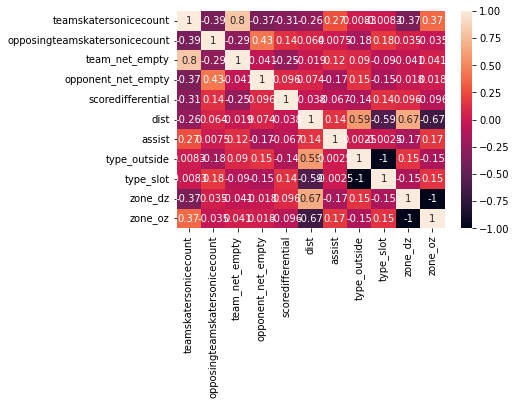

In [41]:
sn.heatmap(xgg[final_vars].corr(), annot=True) # create heatmap 
plt.show() # show plot 

#### Below, I instantiated the classifier fit the model, created a confusion matrix, printed the accuracy score, and displayed the feature importance

Confusion Matrix:
[[14  0]
 [ 1  0]]
Accuracy Score:
93.33333333333333


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

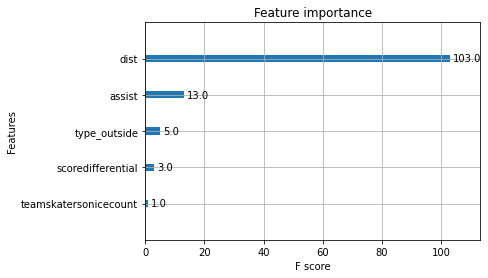

In [42]:
classifier = xgb.XGBClassifier() # instantiate model
classifier.fit(X_train,y_train) # fit model 
y_pred = classifier.predict(X_test) # make predictions 
cm = confusion_matrix(y_test, y_pred) # create confusion matrix 
print('Confusion Matrix:') # make printed stuff easier to see 
print(cm) # print confusion matrix
print('Accuracy Score:') # make printed stuff easier to see
print(accuracy_score(y_test, y_pred)*100) # print accuracy score 
xgb.plot_importance(classifier) # get plot importance 

#### Next, I checked to make sure there was no covariance between the model's features

In [43]:
X = xgg[['compiledgametime','scoredifferential', 'dist', 'assist', 'type_outside']]
# create VIF data frame
vif_data = pd.DataFrame() # instantiate data frame 
vif_data["feature"] = X.columns # create feature name column 
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(str(i)) # print model variables 
print(vif_data) # print VIF data

zone
             feature       VIF
0   compiledgametime  2.163761
1  scoredifferential  1.082910
2               dist  3.990357
3             assist  2.036592
4       type_outside  3.001482


#### Below, I show some of the incomplete code I write while I was trying other feature-selection methods. In the cell immedately below I checked for multicolinarity among my manual model combinations using VIF. I excluded models whose varaibles had VIF values greater than 5 because this indicates strong multicolinarity. In the end, I created eight models whose combinations made sense, given my hockey background and infomration I've gained from this exercise.

In [44]:

# the independent variables set
mod1 = ['compiledgametime','team_net_empty','opponent_net_empty','scoredifferential', 'dist', 'assist','type_slot']
mod2 = ['opponent_net_empty','scoredifferential', 'dist','assist','type_slot']
mod3 = ['compiledgametime','team_net_empty','scoredifferential','zone_oz']
mod4 = ['compiledgametime','team_net_empty','opponent_net_empty','scoredifferential','assist','type_slot', 'zone_dz']
mod5 = ['opposingteamskatersonicecount','team_net_empty','opponent_net_empty','scoredifferential','assist','type_slot']
mod6 = ['team_net_empty','opponent_net_empty','scoredifferential', 'dist','assist', 'zone_dz']
mod7 = ['opponent_net_empty', 'dist', 'type_slot', 'assist', 'scoredifferential']
mod8 = ['opponent_net_empty', 'dist', 'type_slot', 'assist', 'scoredifferential', 'type_outside']
mod9 = ['teamskatersonicecount','team_net_empty','opponent_net_empty', 'dist']
mods = [mod1, mod2, mod3, mod4, mod5, mod6, mod7, mod8, mod9]
for i in mods: 
        X = xgg[i]
        # create VIF dataframe
        vif_data = pd.DataFrame()
        vif_data["feature"] = X.columns
        # calculating VIF for each feature
        vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
        print(str(i)) # print model variables 
        print(vif_data) # print VIF data

['compiledgametime', 'team_net_empty', 'opponent_net_empty', 'scoredifferential', 'dist', 'assist', 'type_slot']
              feature       VIF
0    compiledgametime  2.999342
1      team_net_empty  1.395274
2  opponent_net_empty  1.110909
3   scoredifferential  1.179195
4                dist  2.622402
5              assist  2.594510
6           type_slot  1.895715
['opponent_net_empty', 'scoredifferential', 'dist', 'assist', 'type_slot']
              feature       VIF
0  opponent_net_empty  1.056111
1   scoredifferential  1.073286
2                dist  1.984208
3              assist  2.515187
4           type_slot  1.570638
['compiledgametime', 'team_net_empty', 'scoredifferential', 'zone_oz']
             feature       VIF
0   compiledgametime  3.852943
1     team_net_empty  1.344948
2  scoredifferential  1.163059
3            zone_oz  3.319244
['compiledgametime', 'team_net_empty', 'opponent_net_empty', 'scoredifferential', 'assist', 'type_slot', 'zone_dz']
              feature 

#### Below, I was trying recursive feature elimination feature selection

In [45]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter=100000)
y=['goal']
x=final_vars
X_train,X_test,y_train,y_test=train_test_split(xgg[x],xgg['goal'],test_size=0.20,random_state=0)
rfe = RFE(logreg)
rfe = rfe.fit(X_train, y_train.ravel())
print(rfe.support_) # selected features 
print(rfe.ranking_) # selected feature rankings

predvars = [i[1] for i in enumerate(x) if rfe.support_[i[0]] == True] # combine selected varaiables in list
x = xgg[predvars]
y=xgg[y]
predvars

[False  True  True  True False False False False False  True  True]
[2 1 1 1 3 7 4 6 5 1 1]


['opposingteamskatersonicecount',
 'team_net_empty',
 'opponent_net_empty',
 'zone_dz',
 'zone_oz']

# Before you submit:

Please check that you have answered all questions (and sub-questions) to the best of your ability and that every answer can be clearly traced back to work that is shown. If you were unable to produce an answer, please describe and show the work you tried.

Thanks for your time, effort and interest!